In [13]:
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # for resizing
from torch.cuda.amp import autocast, GradScaler
from torchvision import datasets
import math

In [9]:
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


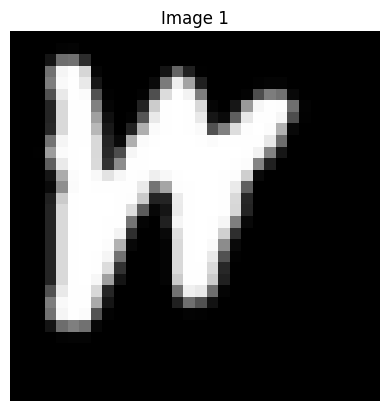

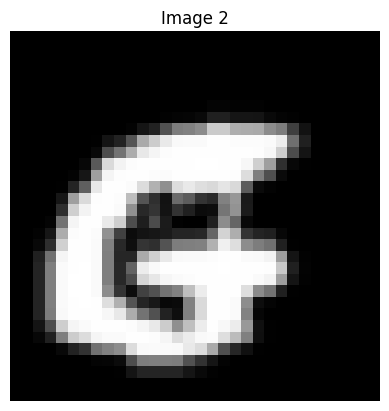

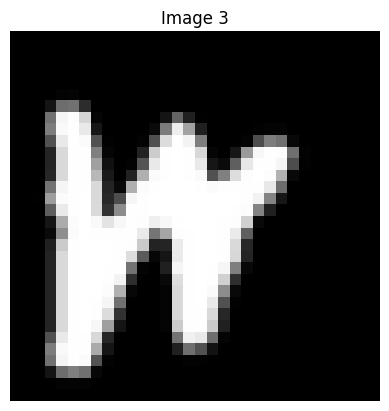

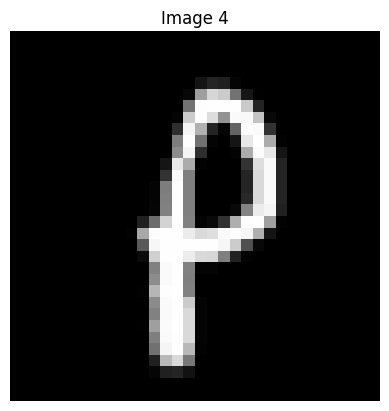

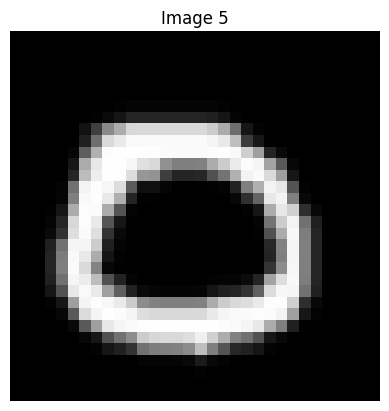

In [10]:
# Open and extract images from the .zip file
def load_images_from_zip(zip_filename):
    """
    Load a numpy array from a .zip archive containing a .npz file.

    Args:
        zip_filename (str): The name of the .zip file to read.

    Returns:
        numpy.ndarray: The loaded array.
    """
    with zipfile.ZipFile(zip_filename, "r") as zipf:
        npz_filename = zipf.namelist()[0]  # Get the name of the .npz file
        zipf.extract(npz_filename)  # Extract the .npz file
    data = np.load(npz_filename)["all_imagesfinal"]  # Load the array
    return data


# Example usage
loaded_images = load_images_from_zip("corrupted_emnist.zip")

# Show the first 5 images
for i in range(5):
    plt.imshow(loaded_images[i], cmap="gray")
    plt.title(f"Image {i+1}")
    plt.axis("off")
    plt.show()

In [11]:
# Define transformations: convert to tensor and normalize to [-1, 1] range
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

# Load the MNIST dataset
mnist_data = datasets.MNIST(
    root="mnist_data", train=True, download=True, transform=transform
)

# Create a DataLoader for batching
mnist_loader = DataLoader(mnist_data, batch_size=128, shuffle=True)

# Check dataset size
print(f"Number of samples in MNIST training dataset: {len(mnist_data)}")

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.28MB/s]


Extracting mnist_data\MNIST\raw\train-images-idx3-ubyte.gz to mnist_data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 356kB/s]


Extracting mnist_data\MNIST\raw\train-labels-idx1-ubyte.gz to mnist_data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.88MB/s]


Extracting mnist_data\MNIST\raw\t10k-images-idx3-ubyte.gz to mnist_data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.53MB/s]

Extracting mnist_data\MNIST\raw\t10k-labels-idx1-ubyte.gz to mnist_data\MNIST\raw

Number of samples in MNIST training dataset: 60000


In [12]:
# Enable GPU
device = torch.device(
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

print(device)


cuda


In [24]:
# Code corrected with the help of GPT (time embedding)


class TimeEmbedding(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        self.linear1 = nn.Linear(embed_size, embed_size)
        self.linear2 = nn.Linear(embed_size, embed_size)

    def forward(self, t):
        half_dim = self.linear1.in_features // 2
        emb = torch.exp(
            torch.arange(half_dim, device=t.device) * -math.log(10000) / (half_dim - 1)
        )
        emb = torch.cat(
            [torch.sin(t[:, None] * emb), torch.cos(t[:, None] * emb)], dim=1
        )
        return self.linear2(F.relu(self.linear1(emb)))


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.time_embed = TimeEmbedding(embed_size=128)  # Adjust embed_size as needed

        # Update encoder to handle increased input channels
        self.encoder = nn.Sequential(
            nn.Conv2d(
                1 + 128, 64, 3, padding=1
            ),  # Input channels: 1 (image) + 128 (time embedding)
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, 3, padding=1),
        )

    def forward(self, x, t):
        # Generate time embeddings and concatenate with input
        t_embed = self.time_embed(t).unsqueeze(-1).unsqueeze(-1)
        t_embed = t_embed.repeat(1, 1, x.size(2), x.size(3))
        x = torch.cat([x, t_embed], dim=1)

        # Encode and decode
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [25]:
# add_noise corrected with the help of GPT

# Diffusion parameters
T = 100  # Number of timesteps
betas = torch.linspace(1e-4, 0.02, T)  # Noise schedule
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0).to(device)


# Sample noisy images
def add_noise(x0, t):
    noise = torch.randn_like(x0)
    alpha_t = alphas_cumprod[t].view(-1, 1, 1, 1)  # Proper broadcasting
    noisy_image = torch.sqrt(alpha_t) * x0 + torch.sqrt(1 - alpha_t) * noise
    return noisy_image, noise


# Reverse process
def denoise(model, xt, t):
    return model(xt, t)


In [26]:
# Prepare MNIST dataset
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
mnist_data = datasets.MNIST(
    root="mnist_data", train=True, download=True, transform=transform
)
mnist_loader = DataLoader(mnist_data, batch_size=128, shuffle=True)


In [45]:
# Code made faster by implementing mixed precision with the help of GPT

# Move model and data to GPU
model = UNet().to(device)

# Initialize model, loss, and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


# Initialize GradScaler for mixed precision
scaler = GradScaler()

# Training loop with mixed precision cause it was slow
epochs = 10  # Define number of epochs
for epoch in range(epochs):
    for images, _ in mnist_loader:  # Labels are not used
        images = images.to(device)
        t = torch.randint(0, T, (images.size(0),), device=device)  # Random time steps
        t_normalized = t.float() / T  # Normalize time step
        xt, noise = add_noise(images, t)

        optimizer.zero_grad()
        with autocast():
            pred_noise = model(xt, t_normalized)
            loss = criterion(pred_noise, noise)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")

# Save the trained model
torch.save(model.state_dict(), "diffusion_mnist.pth")


C:\Users\ameya\AppData\Local\Temp\ipykernel_15740\1916067640.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\ameya\AppData\Local\Temp\ipykernel_15740\1916067640.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/10, Loss: 0.2821
Epoch 2/10, Loss: 0.1762
Epoch 3/10, Loss: 0.1659
Epoch 4/10, Loss: 0.1214
Epoch 5/10, Loss: 0.1501
Epoch 6/10, Loss: 0.1068
Epoch 7/10, Loss: 0.1410
Epoch 8/10, Loss: 0.1129
Epoch 9/10, Loss: 0.1077
Epoch 10/10, Loss: 0.0960


In [46]:
# Normalize and convert corrupted EMNIST to tensors
emnist_images = loaded_images / 255.0  # Scale to [0, 1]
emnist_images = (emnist_images - 0.5) / 0.5  # Normalize to [-1, 1]
emnist_images_tensor = torch.tensor(emnist_images, dtype=torch.float32).unsqueeze(
    1
)  # Add channel dimension

# Create DataLoader for corrupted EMNIST
batch_size = 128
emnist_dataset = torch.utils.data.TensorDataset(emnist_images_tensor)
emnist_loader = torch.utils.data.DataLoader(
    emnist_dataset, batch_size=batch_size, shuffle=False
)


In [49]:
# Load the trained model
model.load_state_dict(torch.load("diffusion_mnist.pth", map_location=device))
model.eval()

# Anomaly detection on corrupted EMNIST
reconstruction_errors = []
pred_noises = []
original_images = []

with torch.no_grad():
    for (images,) in emnist_loader:
        images = images.to(device)
        t = torch.randint(0, T, (images.size(0),), device=device)  # Random time steps
        t_normalized = t.float() / T  # Normalize time steps

        # Add noise to images
        xt, noise = add_noise(images, t)

        # Predict noise using the trained model
        pred_noise = model(xt, t_normalized)

        # Compute reconstruction error
        errors = torch.mean((xt - pred_noise) ** 2, dim=[1, 2, 3])  # MSE per image
        reconstruction_errors.append(errors.cpu())
        pred_noises.append(pred_noise.cpu())
        original_images.append(images.cpu())

# Combine all batches
reconstruction_errors = torch.cat(reconstruction_errors)
pred_noises = torch.cat(pred_noises)
original_images = torch.cat(original_images)


C:\Users\ameya\AppData\Local\Temp\ipykernel_15740\672038496.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("diffusion_mnist.pth", map_l

In [51]:
# Calculate mean and std of reconstruction errors
mean_error = reconstruction_errors.mean().item()
std_error = reconstruction_errors.std().item()
threshold = mean_error + 3 * std_error
anomalies = reconstruction_errors > threshold

# Print anomaly statistics
print(f"Mean Reconstruction Error: {mean_error:.4f}")
print(f"Standard Deviation of Reconstruction Error: {std_error:.4f}")
print(f"Threshold for Anomalies: {threshold:.4f}")
print(f"Number of Anomalies: {torch.sum(anomalies).item()}")


Mean Reconstruction Error: 0.9380
Standard Deviation of Reconstruction Error: 0.4052
Threshold for Anomalies: 2.1537
Number of Anomalies: 88


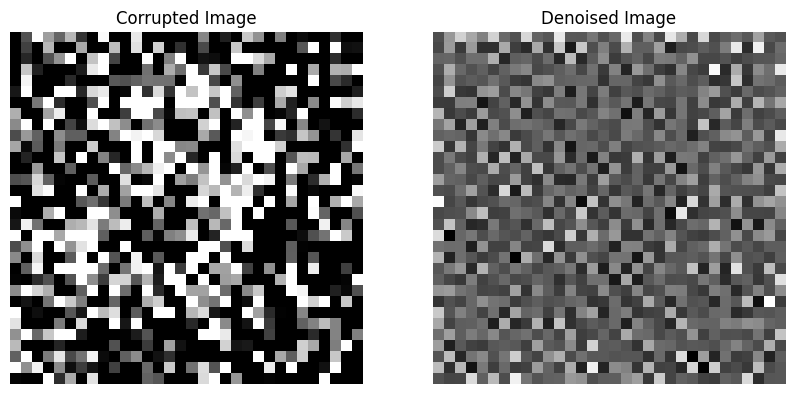

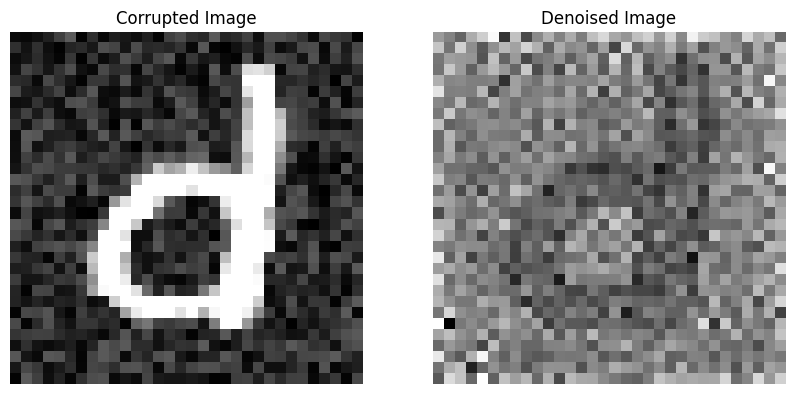

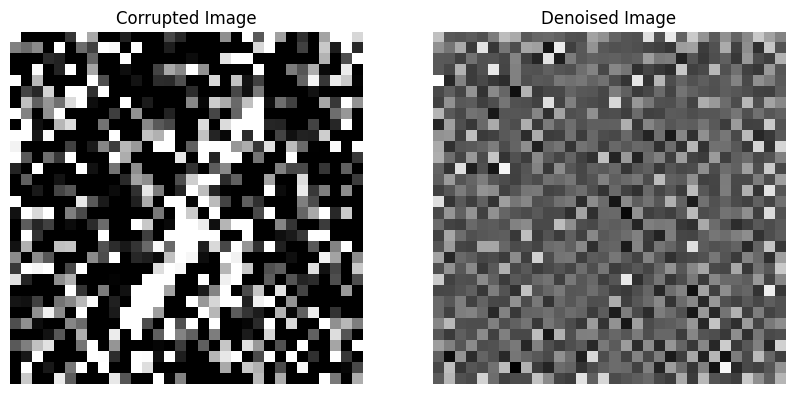

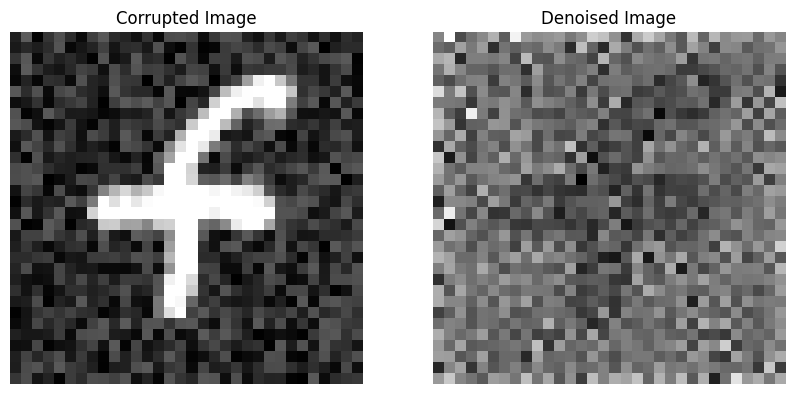

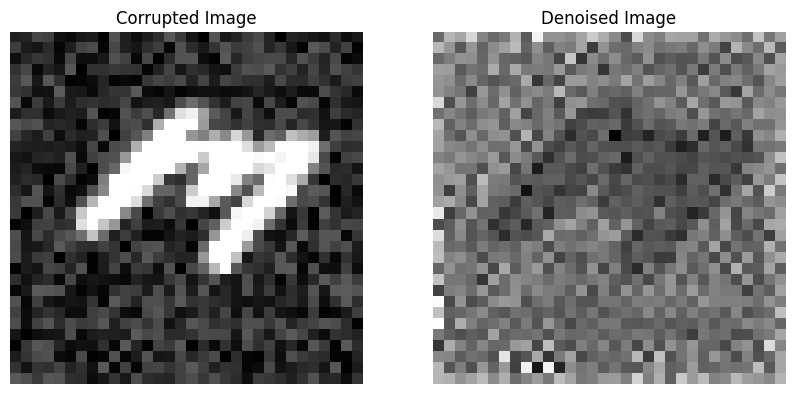

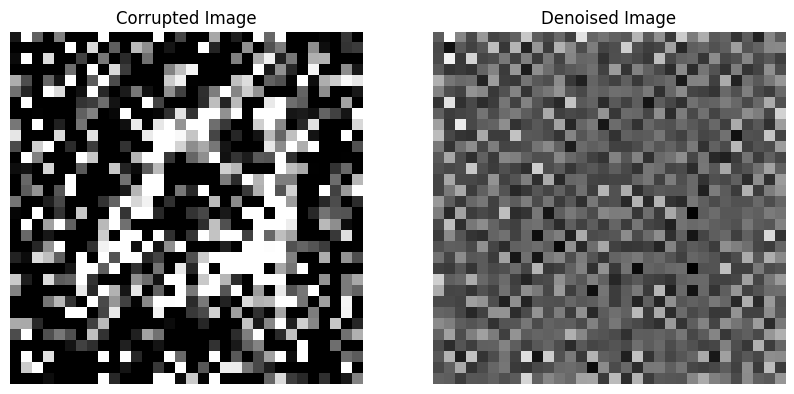

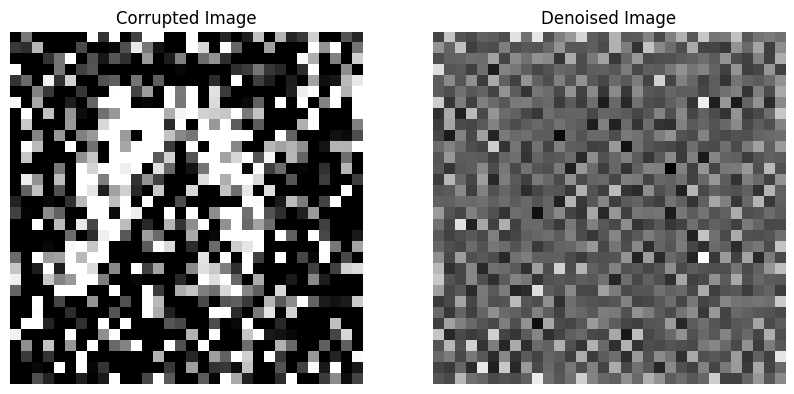

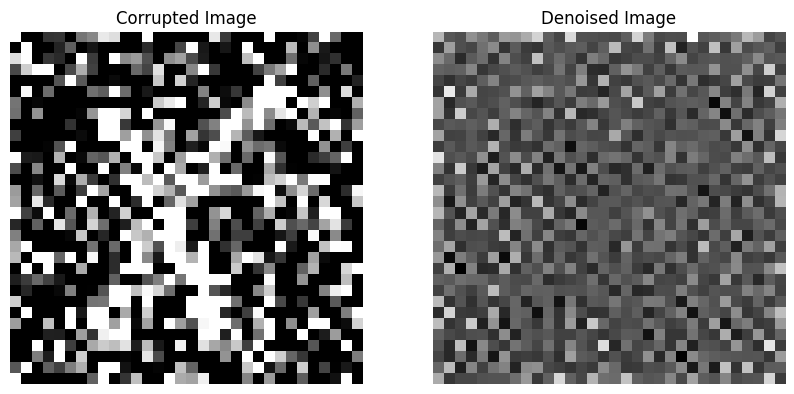

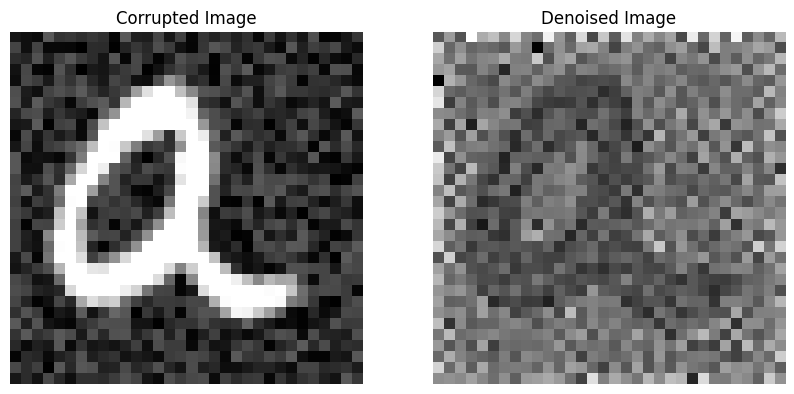

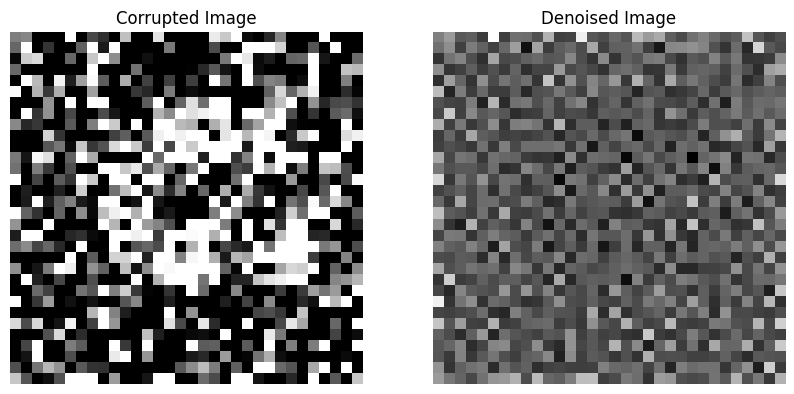

In [52]:
# Code fixed with the help of GPT

# Visualize anomalies
visualized = 0  # Counter for visualized anomalies
max_visualizations = 10  # Maximum anomalies to visualize

for i in range(len(anomalies)):  # Iterate through all images
    if anomalies[i]:  # Check if the image is an anomaly
        corrupted_image = original_images[i].squeeze().numpy()
        denoised_image = pred_noises[i].squeeze().numpy()

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(corrupted_image, cmap="gray")
        plt.title("Corrupted Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(denoised_image, cmap="gray")
        plt.title("Denoised Image")
        plt.axis("off")

        plt.show()

        visualized += 1
        if visualized >= max_visualizations:
            break  # Stop after visualizing max_visualizations anomalies

if visualized == 0:
    print("No anomalies found for visualization.")
